In [1]:
import sqlite3
import requests
import json
import warnings
import re
from datetime import datetime, date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import polars as pl

In [2]:
def get_marketdata(isin, try_counter = 1):
    # Подключение к API мосбиржи

    # Проверка количества попыток для подключения (максимум 4)
    if try_counter >= 4:
        warnings.warn("Попытки подключения к API мосбиржи оказались неудачными", RuntimeWarning)
        return
    
    url = f"https://iss.moex.com/iss/engines/stock/markets/bonds/securities/{isin}.json"
    response = requests.get(url)  # запрос данных по url

    # Проверка успешного подключения
    if response.status_code != 200:
        warnings.warn("Не удалось подключиться к API мосбиржи", RuntimeWarning)

        # Выполняем повторное подключение
        get_marketdata(isin, try_counter = try_counter + 1)
        return
    
    data = response.json()  # Преобразование ответа в JSON

    # Получение данных из блока securities
    inf = get_securities_block(isin, data)

    # Получение данных из блока marketdata
    inf1 = get_marketdata_block(inf, isin, data)

    # Получение данных из блока marketdata_yields
    inf2 = get_marketdata_yields_block(inf1, isin, data)

    if inf2:
        # Сохранение в базу данных
        db = DatabaseManager('bonds.db')
        db.insert_dict("bonds_info", inf2)
    else:
        print(f"Информация по {isin} не найдена")


In [3]:
def get_securities_block(isin, data) -> dict:
    # Получение данных из блока securities

    try:
        # Возможно имеет смысл добавить обработку try except для каждого получаемого поля
        
        inf = {}
        # SECID (ISIN)
        inf[data["securities"]["columns"][0]] = data["securities"]["data"][0][0]
        inf[data["securities"]["columns"][0]] = data["securities"]["data"][0][0]
        
        # get boardid (режим торгов)
        inf[data["securities"]["columns"][1]] = data["securities"]["data"][0][1]
    
        # значение купона
        inf[data["securities"]["columns"][5]] = data["securities"]["data"][0][5]
    
        # дата следующего купона
        inf[data["securities"]["columns"][6]] = data["securities"]["data"][0][6]
    
        # Lotsize (лотность)
        inf[data["securities"]["columns"][9]] = data["securities"]["data"][0][9]
    
        # facevalue (номинал)
        inf[data["securities"]["columns"][10]] = data["securities"]["data"][0][10]
    
        # status
        inf[data["securities"]["columns"][12]] = data["securities"]["data"][0][12]
    
        # matdate (Дата погашения)
        inf[data["securities"]["columns"][13]] = data["securities"]["data"][0][13]
    
        # COUPONPERIOD 
        inf[data["securities"]["columns"][15]] = data["securities"]["data"][0][15]
    
        # ISSUESIZE
        inf[data["securities"]["columns"][16]] = data["securities"]["data"][0][16]
    
        # SECNAME
        inf[data["securities"]["columns"][19]] = data["securities"]["data"][0][19]
    
        # FACEUNIT (валюта)
        inf[data["securities"]["columns"][25]] = data["securities"]["data"][0][25]
    
        # ISIN
        inf[data["securities"]["columns"][28]] = data["securities"]["data"][0][28]
    
        # COUPONPERCENT (купон в процентах)
        inf[data["securities"]["columns"][35]] = data["securities"]["data"][0][35]
    
        # OFFERDATE (дата оферты)
        inf[data["securities"]["columns"][36]] = data["securities"]["data"][0][36]

    except:
        print(f"Ошибка с ISIN {isin} в блоке securities")
        warnings.warn(f"Информация в блоке securities по бумаге {isin} не найдена", UserWarning)

    finally:
        return inf

In [4]:
def get_marketdata_block(inf, isin, data) -> dict:
    # Получение данных из блока marketdata

    try:
        # LAST (последняя цена)
        inf[data["marketdata"]["columns"][11]] = data["marketdata"]["data"][0][11]
    
        # VALUE (должна быть цена в рублях)
        inf[data["marketdata"]["columns"][15]] = data["marketdata"]["data"][0][15]
    
        # YIELD (YTM)
        inf[data["marketdata"]["columns"][16]] = data["marketdata"]["data"][0][16]
    
        # VALUE_USD (цена в долларах)
        inf[data["marketdata"]["columns"][17]] = data["marketdata"]["data"][0][17]
    
        # DURATION (в днях)
        inf[data["marketdata"]["columns"][36]] = data["marketdata"]["data"][0][36]
    
        # YIELDTOOFFER (доходность к оферте)
        inf[data["marketdata"]["columns"][56]] = data["marketdata"]["data"][0][56]

    except:
        print(f"Ошибка с ISIN {isin} в блоке marketdata")
        warnings.warn(f"Информация в блоке marketdata по бумаге {isin} не найдена", UserWarning)
        
    finally:
        return inf

In [5]:
def get_marketdata_yields_block(inf, isin, data) -> dict:
    # Получение данных из блока marketdata_yields

    try:
        # YIELDDATE (дата на которую рассчитывается доходность)
        inf[data["marketdata_yields"]["columns"][3]] = data["marketdata_yields"]["data"][0][3]
    
        # YIELDDATETYPE (тип события которое будет в дату на которую рассчитывается доходность)
        inf[data["marketdata_yields"]["columns"][5]] = data["marketdata_yields"]["data"][0][5]
    
        # EFFECTIVEYIELD (эффективная доходность)
        inf[data["marketdata_yields"]["columns"][6]] = data["marketdata_yields"]["data"][0][6]
    
        # ZSPREADBP (z спред)
        inf[data["marketdata_yields"]["columns"][8]] = data["marketdata_yields"]["data"][0][8]
    
        # GSPREADBP (g спред)
        inf[data["marketdata_yields"]["columns"][9]] = data["marketdata_yields"]["data"][0][9]
        
    except:
        print(f"Ошибка с ISIN {isin} в блоке marketdata_yields")
        warnings.warn(f"Информация в блоке marketdata_yields по бумаге {isin} не найдена", UserWarning)

    finally:
        return inf

In [6]:
class DatabaseManager:
    def __init__(self, db_path):
        self.db_path = db_path
    
    def __enter__(self):
        self.conn = sqlite3.connect(self.db_path)
        return self.conn.cursor()
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        if exc_type is None:
            self.conn.commit()
        else:
            self.conn.rollback()
        self.conn.close()

    def is_date_string(self, value):
        """
        Проверяет, является ли строка датой в формате 'YYYY-MM-DD'
        """
        if not isinstance(value, str):
            return False
        
        # Проверка формата YYYY-MM-DD
        pattern = r'^\d{4}-\d{2}-\d{2}$'
        if re.match(pattern, value):
            return True
        
        return False
    
    def insert_dict(self, table_name, data_dict):
        with self as cursor:
            # Проверяем существование таблицы
            cursor.execute("""
                SELECT name FROM sqlite_master 
                WHERE type='table' AND name=?
            """, (table_name,))
            
            table_exists = cursor.fetchone() is not None
            if not table_exists:
                # Создаем таблицу на основе ключей словаря
                columns = []
                for key, value in data_dict.items():
                    if isinstance(value, int):
                        col_type = 'INTEGER'
                    elif isinstance(value, float):
                        col_type = 'REAL'
                    elif self.is_date_string(value):
                        col_type = 'TEXT'
                    else:
                        col_type = 'TEXT'
                    columns.append(f'{key} {col_type}')
                
                create_query = f'''
                    CREATE TABLE {table_name} (
                        id INTEGER PRIMARY KEY AUTOINCREMENT,
                        {", ".join(columns)}
                    )
                '''
                cursor.execute(create_query)
        
            columns = ', '.join(data_dict.keys())
            placeholders = ':' + ', :'.join(data_dict.keys())
            
            # Выполняем запрос - SQLite сам преобразует None в NULL
            cursor.execute(f'''
                INSERT INTO {table_name} ({columns})
                VALUES ({placeholders})
            ''', data_dict)

    def delete_table(self, table_name):
        "Удаление таблицы"
        with self as cursor:
            
            # Проверяем существование таблицы
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name=?", (table_name,))
            if cursor.fetchone():
                # Удаляем таблицу
                cursor.execute(f"DROP TABLE {table_name}")

    def fetch_data_from_sqlite(self, df, keys_list, table_name, join_parameter):
        """Получение данных об облигациях из SQLite по списку ISIN"""

        # Проверка что список ISIN не пустой
        if not keys_list:
            print("Передан пустой список ключей")
            return

        with self as cursor:
            placeholders = ','.join(['?'] * len(keys_list))

            query = f"""
            SELECT *
            FROM {table_name} 
            WHERE secid IN ({placeholders})
            """

            # Если self возвращает курсор, получаем соединение из него
            if hasattr(cursor, 'connection'):
                conn = cursor.connection
            else:
                # Или предполагаем, что cursor это соединение
                conn = cursor

            result_df = pl.read_database(query, conn, execute_options={'parameters': keys_list})
            
            result_df = df.join(result_df, on=join_parameter, how="inner")

            return result_df

    def currency_value(self, currency:str):
        # Получение знчаения валюты currency

        currency += 'FIX'
        
        # Для рублей возвращаем 1
        if currency == 'RUB' or currency == 'RUBFIX':
            return 1
            
        with self as cursor:

            query = """
            SELECT LASTVALUE
            FROM currency
            WHERE secid = ?
            """

            # Выполняем запрос с параметром
            cursor.execute(query, (currency,))

            # Получаем результат
            result = cursor.fetchone()

            return result

In [7]:
def get_currency(try_counter=1):

    # Проверка количества попыток для подключения (максимум 4)
    if try_counter >= 4:
        warnings.warn("Попытки подключения к API мосбиржи оказались неудачными", RuntimeWarning)
        return
    
    url = "https://iss.moex.com/iss/engines/currency/markets/index/securities.json"
    response = requests.get(url)  # запрос данных по url

    # Проверка успешного подключения
    if response.status_code != 200:
        warnings.warn("Не удалось подключиться к API мосбиржи", RuntimeWarning)

        # Выполняем повторное подключение
        get_marketdata(isin, try_counter = try_counter + 1)
        return
    
    data = response.json()  # Преобразование ответа в JSON

    # количество возможных для парсинга валют
    str_number = min(len(data['securities']['data']), len(data['marketdata']['data']))

    inf = {}

    # проходим по всем валютам
    for i in range(str_number):
        
        try:
            # BOARDID
            inf[data['securities']['columns'][0]] = data['securities']['data'][i][0]
        
            # SECID
            inf[data['securities']['columns'][1]] = data['securities']['data'][i][1]
        
            # SHORTNAME
            inf[data['securities']['columns'][2]] = data['securities']['data'][i][2]
        
            # LATNAME
            inf[data['securities']['columns'][3]] = data['securities']['data'][i][3]
        
            # NAME
            inf[data['securities']['columns'][4]] = data['securities']['data'][i][4]
        
            # TRADEDATE
            inf[data['marketdata']['columns'][2]] = data['marketdata']['data'][i][2]
        
            # TIME
            inf[data['marketdata']['columns'][3]] = data['marketdata']['data'][i][3]
        
            # LASTVALUE
            inf[data['marketdata']['columns'][4]] = data['marketdata']['data'][i][4]
        except:
            print(f"Ошибка при загрузке валют")
            warnings.warn(f"Информация не найдена", UserWarning)
            return inf
    
        # Сохранение в базу данных
        db = DatabaseManager('bonds.db')
        db.insert_dict("currency", inf)
        
    print("Данные о валютах обновлены")

In [52]:
get_currency()

Данные о валютах обновлены


In [15]:
import polars as pl

In [46]:
def portfolio_upload(path="bonds.xlsx"):
    # Загрузка портфеля облигаций из эксель файла. Файл содержит 2 столбца: ISIN'ы и доля каждого isin
    try:
        df = pl.read_excel(path)
    except IOError as e:
        print(f"Не найден файл по пути {path}")
        raise e

    try:
        df.cast({'Количество лотов' : pl.Int32})
    except:
        print("В столбце 'Количество лотов' должны быть только целочисловые значения")
        raise ValueError

    if len(df.columns) != 2:
        print("Файл эксель должен состоять из 2 столбцов: 'ISIN' (строковое) и 'Количество лотов' (float) каждого из ISIN в портфеле")
        return


    
     # Подключение к базе данных
    db = DatabaseManager('bonds.db')
    
    # Удаление старой таблицы с данными по облигациям
    db.delete_table("bonds_info")
    
    # обновление данных по каждому ISIN в базе данных
    for row in df.iter_rows():
        get_marketdata(row[0])

    # Уникальные ISIN из датафрейма
    unique_isins = df["ISIN"].unique().to_list()

    bond_data_df = db.fetch_data_from_sqlite(df, unique_isins, "bonds_info", "ISIN")
    
    df = dataframe_proceccing(bond_data_df,
                     date_columns=['NEXTCOUPON', 'MATDATE', 'YIELDDATE', 'OFFERDATE'],
                     drop_columns=['SECID', 'BOARDID', 'id', 'ISSUESIZE'])

    # Уникальные валюты в портфеле
    unique_currency = df['FACEUNIT'].unique().to_list()



    
    df = add_currency_rub(df)

    # Преобразуем количество бумаг в долю в портфеле (по стоимости)
    df = get_share(df)
    
    # return df 


    # Для каждой валюты вычисляем характеристики портфеля
    for currency in unique_currency: # сюда поставить unique_currency вместо list
        filtered_df = df.filter(pl.col('FACEUNIT') == currency)
        if round(filtered_df['Доля'].sum(), 5) > 0:
            # print(filtered_df)
            portfolio_info(filtered_df, currency)
            

    return df

In [19]:
def get_share(df):
    # Добавляет в датафрейм столбец с долей каждой бумаги

    try:
        df.cast({'Количество лотов' : pl.Int32})
    except:
        print("В столбце 'Доля' должны быть только числовые значения")
        raise ValueError

    # Создание стоблца с оставшимися днями до выплаты купона в формате int
    df = df.with_columns(
    pl.col('NEXTCOUPON_delta').dt.total_days().alias('NEXTCOUPON_delta_int')
    )
    
    # Расчет полной стоимости каждой облигации в портфеле
    # В идеале брать курс валют ЦБ для правильного расчета, но пока что беру что есть
    df = df.with_columns(
    (pl.col('FACEVALUE') * (pl.col('LAST') / 100) * pl.col('CURRENCY_RUB') * pl.col('Количество лотов') * pl.col('LOTSIZE') +
    (pl.col('COUPONPERIOD') - pl.col('NEXTCOUPON_delta_int')) / pl.col('COUPONPERIOD') * pl.col('COUPONVALUE') * pl.col('CURRENCY_RUB'))
    .alias('FULLVALUE_RUB'))

    full_sum = df['FULLVALUE_RUB'].sum()
    
    df = df.with_columns(
        (pl.col('FULLVALUE_RUB') / full_sum).alias('Доля')
    )

    return df

In [21]:
def dataframe_proceccing(df, date_columns:list = [], drop_columns=[]):
    # обработка датафрейма

    today = date.today()
    
    try:
        for column in date_columns:
            if column:
                df = df.cast({column : pl.Date})
                # Добавление столбцов: дата - текущая дата для всех столбцов где есть даты
                delta_days = (pl.Series(df[column]) - today).alias(f"{column}_delta")
                column_index = df.get_column_index(column)
                df.insert_column(column_index+1, delta_days)
                
    except:
        warnings.warn(f"Возникла ошибка с трансформацией строки в дату.", UserWarning)
        raise

    try:
        for column in drop_columns:
            df = df.drop(column)
    except:
        warnings.warn(f"Возникла ошибка с при удалении столбца.", UserWarning)

    return df

In [23]:
def get_riskoff_yeilds(currency):
    # В зависимости от валюты выбирабтся безрисковые доходности
    if currency == 'RUB':
        df = rub_yield()
        return df
    elif currency == 'USD':
        df = usd_yield()
        return df
    elif currency == 'CNY':
        df = cny_yield()
        return df
    elif currency == 'EUR':
        df = euro_yield()
        return df
    else:
        df = pl.DataFrame()
        return df
    

In [25]:
def rub_yield():
    # Получение безрисковых ставок с api мосбиржи
    today = date.today()
    day_counter = 0

    url = f'https://iss.moex.com/iss/engines/stock/zcyc.json?date={today}'
    response = requests.get(url)  # запрос данных по url  
    data = response.json()  # Преобразование ответа в JSON

    # если выходной или праздник, то в этот день нет данных - пропускаем его и идем дальше
    while not data['yearyields']['data'] and day_counter < 30:
        today = today - timedelta(days=1)
        url = f'https://iss.moex.com/iss/engines/stock/zcyc.json?date={today}'
        response = requests.get(url)  # запрос данных по url  
        data = response.json()  # Преобразование ответа в JSON

    # Названия столбцов
    schema = data['yearyields']['columns']

    # Данные
    lsts = [[], [], [], []]

    for i in range(len(data['yearyields']['data'])):
        lsts[0].append(data['yearyields']['data'][i][0])
        lsts[1].append(data['yearyields']['data'][i][1])
        lsts[2].append(data['yearyields']['data'][i][2])
        lsts[3].append(data['yearyields']['data'][i][3])

    # Создание датафрейма polars
    df = pl.DataFrame(lsts, schema=['tradedate', 'tradetime', 'period', 'value'], orient="col")

    # обработка датафрейма (преобразование в дату и удаление лишних столбцов)
    df = dataframe_proceccing(df, date_columns=['tradedate'], drop_columns=['tradetime', 'tradedate_delta'])

    return df

In [27]:
def usd_yield():
    # Тикеры для основных сроков
    tickers = {
        '0.25': '^IRX',
        '0.50': '^IRX',
        '1.00': '^TNX',   
        '2.00': '^TNX',
        '5.00': '^FVX',
        '10.00': '^TNX',
        '30.00': '^TYX'
    }
    data_records = []
    
    for maturity, ticker in tickers.items():
        try:
            bond_data = yf.Ticker(ticker)
            hist = bond_data.history(period='1d')
            
            if not hist.empty:
                current_yield = hist['Close'].iloc[-1]
                
                data_records.append({
                    'period': maturity,
                    'ticker': ticker,
                    'value': current_yield,
                    'date': datetime.now().date(),
                })

        except Exception as e:
            print(f"Ошибка для {maturity}: {e}")
    
    # Создаем DataFrame Polars
    if data_records:
        df = pl.DataFrame(data_records)
    else:
        df = pl.DataFrame()

    return df

In [29]:
import requests
from bs4 import BeautifulSoup
def cny_yield():
    # Получение безрисковой ставки для юаней (CNY)

    try:
        url = 'https://yield.chinabond.com.cn/cbweb-czb-web/czb/moreInfo?locale=en_US&nameType=1'
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'lxml')
    except:
        print()
        print("!!! НЕ УДАЛОСЬ ПОДКЛЮЧИТЬСЯ К САЙТУ ДЛЯ ПАРСИНГА БЕЗРИСКОВОЙ ДОХОДНОСТИ ДЛЯ ЮАНЕЙ !!!")
        print()

    try:
        soup1 = soup.find('div', id='gjqxData')
        trs = soup1.find_all('tr')
        
        data = []
        
        for i in trs:
            temp = []
            for j in i.find_all('td'):
                # Проверка формата YYYY-MM-DD (строку с датой не добавляем )
                pattern = r'^\d{4}-\d{2}-\d{2}$'
                if re.match(pattern, j.text) or j.text == 'Date':
                    continue
                else:
                    # print(j.text)
                    temp.append(j.text)
            data.append(temp)
    except:
        print()
        print("!!! НЕ УДАЛОСЬ ОБРАБОТАТЬ HTML ДЛЯ ПАРСИНГА БЕЗРИСКОВОЙ ДОХОДНОСТИ ДЛЯ ЮАНЕЙ !!!")
        print()
    
    titles = data[0]
    data = data[1:]
    
    df = pl.DataFrame(data, schema=titles, orient='row')
    
    # Переименовываем столбцы
    df = df.rename({"Maturity": "period", "Yield(%)": "value"})
    
    # Замена старых названий для периода
    true_period = [0.25, 0.5, 1.00, 2.00, 3.00, 5.00, 7.00, 10.00, 30.00]
    
    df = df.with_columns(
        pl.Series('period', true_period)
    )

    # Конвератция доходности из string в float
    df = df.cast({"value": pl.Float32})
    
    return df

In [31]:
from fake_useragent import UserAgent

def euro_yield():
    # Парсинг безрисковой ставки по ЕВРО с сайта Investing.com
    # В качестве безрисковой выбрана доходность государственных облигаций Германии

    # Класс для создания рандомного useragent
    ua = UserAgent()

    # Сбор HTML с сайта Investing
    try:
        with requests.Session() as session:
            session.headers.update({
                'User-Agent': ua.random,
                'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
            })
            response = session.get("https://www.investing.com/rates-bonds/germany-government-bonds")
        
        soup = BeautifulSoup(response.text, 'lxml')
    except:
        print()
        print("!!! НЕ УДАЛОСЬ ПОДКЛЮЧИТЬСЯ К САЙТУ INVESING.COM !!!")
        print()
        raise

    try:
        # Нахождение нужного блока          
        soup1 = soup.find('table', class_='genTbl closedTbl crossRatesTbl')
        soup2 = soup1.find('tbody')
        soup3 = soup2.find_all('tr')

        names = [] # Названия периода
        values = [] # Доходности для периода
        
        for i in soup3:
            name = i.find_all('td')[1].text # Сбор названия периода
            value = i.find_all('td')[2].text # Сбор доходности
            names.append(name)
            values.append(value)
    except:
        print()
        print("!!! НЕ УДАЛОСЬ НАЙТИ НУЖНЫЙ БЛОК В HTML !!!")
        print()
        raise
    
    
    # Соответствие периодов 
    corres_table = {
        'Germany 3M' : 0.25,
        'Germany 6M' : 0.5,
        'Germany 9M' : 0.75,
        'Germany 1Y' : 1.00,
        'Germany 2Y' : 2.00,
        'Germany 3Y' : 3.00,
        'Germany 4Y' : 4.00,
        'Germany 5Y' : 5.00,
        'Germany 6Y' : 6.00,
        'Germany 7Y' : 7.00,
        'Germany 8Y' : 8.00,
        'Germany 9Y' : 9.00,
        'Germany 10Y' : 10.00,
        'Germany 15Y' : 15.00,
        'Germany 20Y' : 20.00,
        'Germany 25Y' : 25.00,
        'Germany 30Y' : 30.00}
    
    # Применяем соответствие периодов
    true_period = [corres_table[item] if item in corres_table else item for item in names]

    if not true_period:
        print()
        print("!!! ОШИБКА В ТАБИЦЕ КОРРЕКТИРОВКИ !!!")
        print()
        raise
    
    data = {'period' : true_period, 'value' : values}
    df = pl.DataFrame(data)
    df = df.cast({"value": pl.Float32})
    
    return df

In [33]:
def freerisk_plot(weighted_YTM, weighted_maturity_date, currency):
    # Построение графика с эффективной доходностью портфеля относительно
    # безрисковой доходности

    df = get_riskoff_yeilds(currency)

    # Проверка существования данных по безрисковой ставке для нужной валюты 
    if df.is_empty():
        print(f"\nНет данных для расчета безрисковой ставки по валюте {currency}!\n")
        return None
    
    # Основной график с настройками
    ax = sns.lineplot(data=df, x='period', y='value',
                     markers=True, linewidth=2, marker='o',
                     markersize=6, color='#3498DB',
                     markerfacecolor='white',  # Белая заливка маркеров
                     markeredgewidth=2, markeredgecolor='#3498DB',
                     label='Безрисковая доходность')
    
    # Добавляем специальную точку
    special_point = plt.scatter(x=weighted_YTM, y=weighted_maturity_date, 
                               color='#E74C3C', s=100, zorder=5,
                               edgecolors='black', linewidth=2,
                               label='Портфель')
    
    # Настройки оформления
    title = f'Доходность {currency} портфеля на бизрисковой кривой'
    plt.title(title, 
              fontsize=14, fontweight='bold', pad=25)
    plt.xlabel('Срок, лет', fontsize=14, labelpad=10)
    plt.ylabel('Эффективная доходность, %', fontsize=14, labelpad=10)
    
    # Улучшаем сетку и внешний вид
    plt.grid(True, alpha=0.4, linestyle='--')
    plt.legend(fontsize=12, framealpha=0.9)
    
    # Убираем лишние рамки
    sns.despine(left=True, bottom=True)
    
    plt.tight_layout()
    plt.show()

In [41]:
def portfolio_info(df, currency):
    # Расчет показателей портфеля

    weighted_YTM = 0.0
    weighted_duration = 0.0
    weighted_couponperid = 0.0
    weighted_couponpercent = 0.0
    weighted_yield = 0.0
    weighted_maturity_date = 0.0

    # пересчет долей
    sum_share = df['Доля'].sum()
    df = df.with_columns(
        (pl.col('Доля') / sum_share).alias('Доля')  # то же имя столбца
    )


    for row in df.iter_rows():
        # взвешенный купонный период
        weighted_couponperid += row[-1] * row[10]

        # взвешенный YTM
        weighted_YTM += row[-1] * row[25]

        # взвешенная дюрация
        weighted_duration += row[-1] * row[20]

        # взвешенный процент по купонам
        weighted_couponpercent += row[-1] * row[13]

        # взвешенная доходность
        weighted_yield += row[-1] * row[18]

        # Взвешенный срок до погашения
        weighted_maturity_date += row[-1] * (row[9].total_seconds() / 86400)

        # # Взвешенный срок до события
        # weighted_maturity_date += row[1] * (row[7].total_seconds() / 86400)       

    print(f"Информация по портфелю в валюте {currency}")
    print(f"YTM портфеля: {round(weighted_YTM, 2)}%")
    print(f"Доходность портфеля: {round(weighted_yield, 2)}%")
    print(f"Дюрация портфеля: {round(weighted_duration, 2)} дней")
    print(f"Взвешенный процент по купонам: {round(weighted_couponpercent, 2)}")
    print(f"Взвешенный купонный период по портфелю: {round(weighted_couponperid, 2)} дней")
    print(f"Взвешенный срок до погашения: {round(weighted_maturity_date, 2)} дней")
    print(f"Взвешенный срок до погашения: {round(weighted_maturity_date / 365, 3)} лет")

    freerisk_plot(weighted_maturity_date / 365, weighted_YTM, currency)

In [37]:
def add_currency_rub(df):
    # Добавление стоимости валюты в рублях для каждой облигации
    
    # Уникальные валюты в датафрейме
    unique_currency = df['FACEUNIT'].unique().to_list()

    # Получение значения валюты в рублях для каждой уникльной валюты в датафрейме
    db = DatabaseManager('bonds.db')
    values = []
    for currency in unique_currency:
        value = db.currency_value(currency)
        if value == 1: # обработка для рублей
            values.append(float(value))
        elif value is not None: # если валюта найдена
            values.append(float(value[0]))
        else:
            values.append(0)
            print(f"Значение для валюты {currency} не найдены!")

    # Словарь валюта : значение в рублях
    currencies = dict(zip(unique_currency, values))

    # Вставка столбца в датафрейм
    df = df.with_columns(
    pl.col('FACEUNIT').replace(currencies).alias('CURRENCY_RUB')
    )

    # Преобразование столбца в flaot формат
    df = df.cast({'CURRENCY_RUB' : pl.Float32})

    return df

In [75]:
from datetime import datetime, date
from dateutil.relativedelta import relativedelta

def create_monthly_dict(end_date):
    """
    Ежемесячный календарь с текущего месяца по максимальную в dataframe
    """
    current_year = datetime.now().year
    start_date = date(current_year, 1, 1)
    # end_date = datetime.strptime(end_date, "%Y-%m-%d").date()
    
    monthly_dict = {}
    current = start_date
    
    while current <= end_date:
        monthly_dict[current] = 0
        # Переходим к следующему месяцу
        current += relativedelta(months=1)
        current = current.replace(day=1)  # Обеспечиваем первый день месяца
    
    return monthly_dict

Информация по портфелю в валюте EUR
YTM портфеля: 7.21%
Доходность портфеля: 7.21%
Дюрация портфеля: 724.75 дней
Взвешенный процент по купонам: 1.64
Взвешенный купонный период по портфелю: 365.0 дней
Взвешенный срок до погашения: 747.48 дней
Взвешенный срок до погашения: 2.048 лет


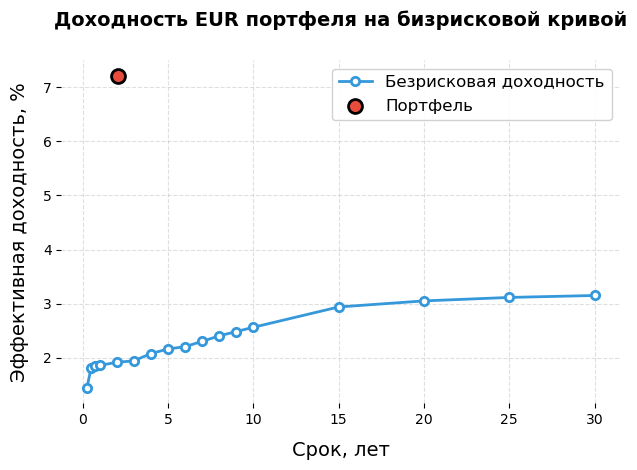

Информация по портфелю в валюте USD
YTM портфеля: 8.82%
Доходность портфеля: 8.82%
Дюрация портфеля: 490.2 дней
Взвешенный процент по купонам: 4.54
Взвешенный купонный период по портфелю: 174.68 дней
Взвешенный срок до погашения: 510.76 дней
Взвешенный срок до погашения: 1.399 лет


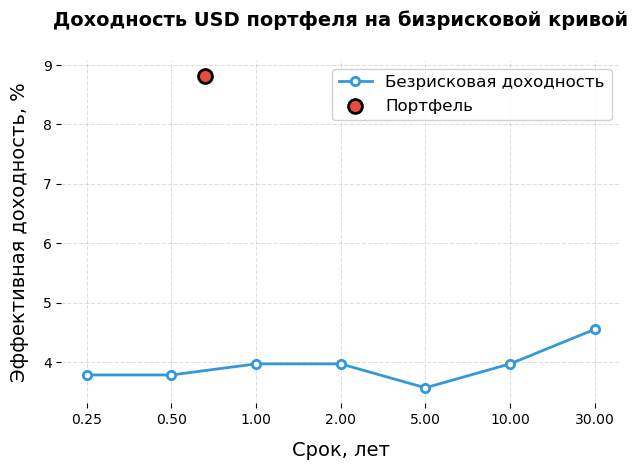

Информация по портфелю в валюте CNY
YTM портфеля: 8.09%
Доходность портфеля: 8.09%
Дюрация портфеля: 495.51 дней
Взвешенный процент по купонам: 8.52
Взвешенный купонный период по портфелю: 30.0 дней
Взвешенный срок до погашения: 526.8 дней
Взвешенный срок до погашения: 1.443 лет


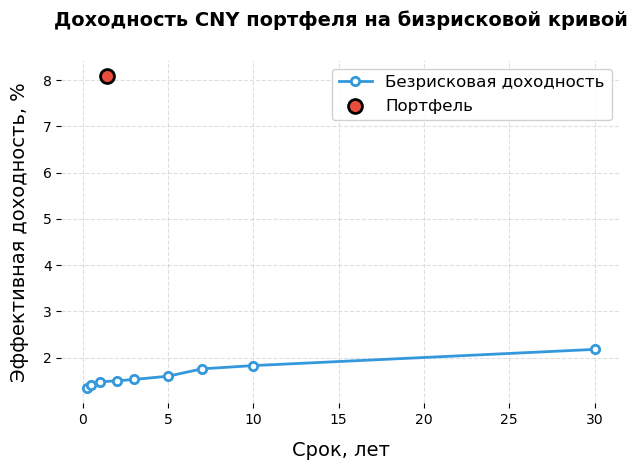

ISIN,Количество лотов,COUPONVALUE,NEXTCOUPON,NEXTCOUPON_delta,LOTSIZE,FACEVALUE,STATUS,MATDATE,MATDATE_delta,COUPONPERIOD,SECNAME,FACEUNIT,COUPONPERCENT,OFFERDATE,OFFERDATE_delta,LAST,VALUE,YIELD,VALUE_USD,DURATION,YIELDTOOFFER,YIELDDATE,YIELDDATE_delta,YIELDDATETYPE,EFFECTIVEYIELD,ZSPREADBP,GSPREADBP,CURRENCY_RUB,NEXTCOUPON_delta_int,FULLVALUE_RUB,Доля
str,i64,f64,date,duration[μs],i64,i64,str,date,duration[μs],i64,str,str,f64,date,duration[μs],f64,f64,f64,f64,i64,null,date,duration[μs],str,f64,i64,i64,f32,i64,f64,f64
"""RU000A10B4J5""",1,1.13,2025-11-16,25d,1,100,"""A""",2027-03-11,505d,30,"""Полипласт АО П02-БО-03""","""USD""",13.7,null,null,102.748,75224.64,12.22,924.73,462,null,2027-03-11,505d,"""MATDATE""",12.2174,-202,-196,79.705002,25,8204.540637,0.001251
"""RU000A10BS68""",2,1.05,2025-11-08,17d,1,100,"""A""",2027-11-28,767d,30,"""Уральская Сталь БО-001Р-04""","""USD""",12.75,null,null,102.1051,49835.97,12.28,612.63,674,null,2027-11-28,767d,"""MATDATE""",12.2813,-243,-236,79.705002,17,16312.840141,0.002487
"""RU000A10BQV8""",3,0.99,2025-11-02,11d,1,100,"""A""",2028-06-19,971d,30,"""Инвест КЦ 001P-01""","""USD""",12.0,null,null,102.1667,8311.01,11.68,102.17,832,null,2028-06-19,971d,"""MATDATE""",11.6826,-324,-317,79.705002,11,24479.566068,0.003732
"""RU000A10CM89""",4,1.19,2025-11-01,10d,1,100,"""A""",2027-08-23,670d,30,"""КИФА БО-01""","""CNY""",14.5,null,null,100.9888,1147.69,14.78,14.11,587,null,2027-08-23,670d,"""MATDATE""",14.7825,23,31,11.082,10,4485.423157,0.000684
"""RU000A10CCJ1""",5,1.1,2025-11-13,22d,1,100,"""A""",2028-09-01,1045d,31,"""Славянск ЭКО 001Р-04""","""USD""",13.0,null,null,99.6515,16212.8,13.91,199.3,875,null,2028-09-01,1045d,"""MATDATE""",13.9094,-106,-100,79.705002,22,39739.069128,0.006059
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""RU000A105BY1""",13,18.5,2025-11-17,26d,1,1000,"""A""",2028-11-17,1122d,365,"""Газпром капитал ООО ЗО28-1-Е""","""EUR""",1.85,null,null,85.8042,162454.12,7.16,1997.04,1077,null,2028-11-17,1122d,"""MATDATE""",7.1588,-801,-800,95.309601,26,1.0648e6,0.162337
"""RU000A108TV3""",14,15.5,2025-12-25,64d,1,1000,"""A""",2027-06-25,611d,183,"""АЛРОСА З027-Д""","""USD""",3.1,null,null,94.3061,230146.96,6.78,2829.18,593,null,2027-06-25,611d,"""MATDATE""",6.7753,-779,-777,79.705002,64,1.0531e6,0.160563
"""RU000A10B0C8""",1,8.38,2025-10-31,9d,1,1000,"""A""",2027-02-23,489d,30,"""МЕТАЛЛОИНВЕСТ 001P-12""","""CNY""",10.2,null,null,104.5,11875.9,6.88,145.99,456,null,2027-02-23,489d,"""MATDATE""",6.8756,-739,-734,11.082,9,11645.696779,0.001776


In [48]:
portfolio_upload()

Информация по портфелю в валюте USD
YTM портфеля: 8.77%
Доходность портфеля: 8.77%
Дюрация портфеля: 490.13 дней
Взвешенный процент по купонам: 4.54
Взвешенный купонный период по портфелю: 174.69 дней
Взвешенный срок до погашения: 510.68 дней
Взвешенный срок до погашения: 1.399 лет


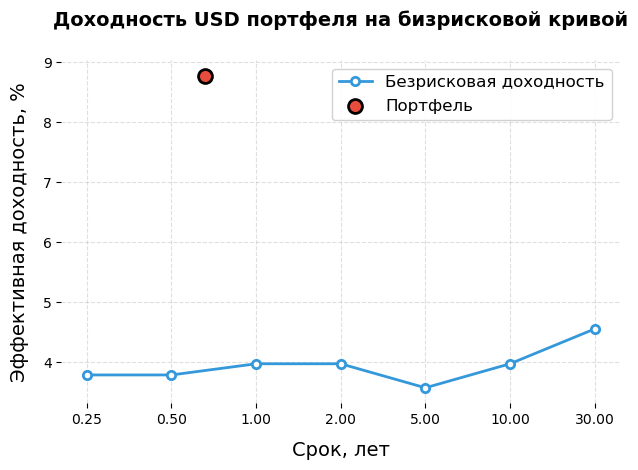

Информация по портфелю в валюте EUR
YTM портфеля: 7.21%
Доходность портфеля: 7.21%
Дюрация портфеля: 724.75 дней
Взвешенный процент по купонам: 1.64
Взвешенный купонный период по портфелю: 365.0 дней
Взвешенный срок до погашения: 747.48 дней
Взвешенный срок до погашения: 2.048 лет


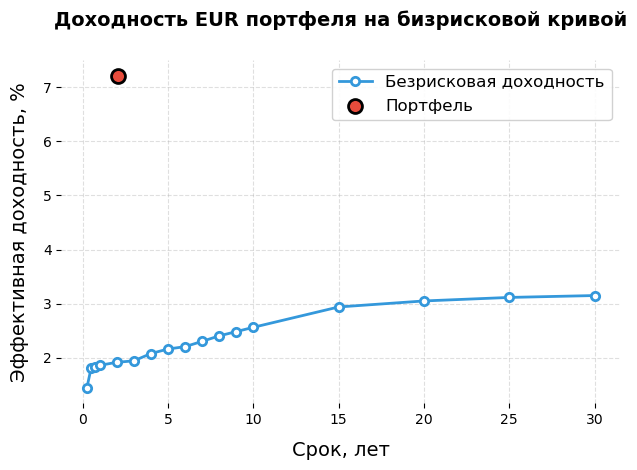

Информация по портфелю в валюте CNY
YTM портфеля: 8.09%
Доходность портфеля: 8.09%
Дюрация портфеля: 495.51 дней
Взвешенный процент по купонам: 8.52
Взвешенный купонный период по портфелю: 30.0 дней
Взвешенный срок до погашения: 526.8 дней
Взвешенный срок до погашения: 1.443 лет


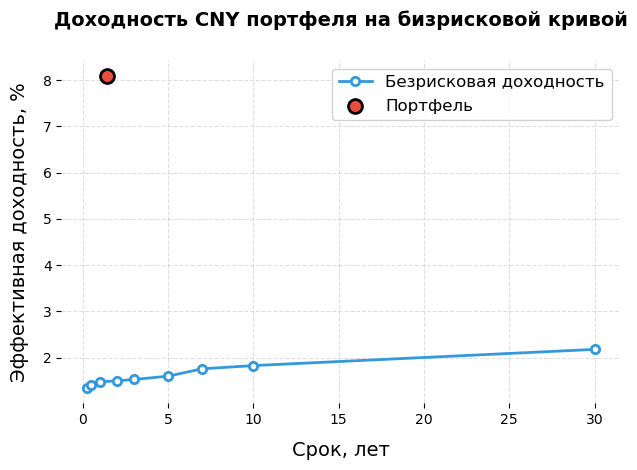

In [51]:
df = portfolio_upload()

In [61]:
cutted_df = df['ISIN', 'COUPONVALUE', 'NEXTCOUPON', 'COUPONPERIOD', 'CURRENCY_RUB', 'Доля', 'MATDATE', 'FACEUNIT', 'FACEVALUE', 'LOTSIZE']
cutted_df

ISIN,COUPONVALUE,NEXTCOUPON,COUPONPERIOD,CURRENCY_RUB,Доля,MATDATE,FACEUNIT,FACEVALUE,LOTSIZE
str,f64,date,i64,f32,f64,date,str,i64,i64
"""RU000A10B4J5""",1.13,2025-11-16,30,79.705002,0.001251,2027-03-11,"""USD""",100,1
"""RU000A10BS68""",1.05,2025-11-08,30,79.705002,0.002487,2027-11-28,"""USD""",100,1
"""RU000A10BQV8""",0.99,2025-11-02,30,79.705002,0.003731,2028-06-19,"""USD""",100,1
"""RU000A10CM89""",1.19,2025-11-01,30,11.082,0.000684,2027-08-23,"""CNY""",100,1
"""RU000A10CCJ1""",1.1,2025-11-13,31,79.705002,0.006057,2028-09-01,"""USD""",100,1
…,…,…,…,…,…,…,…,…,…
"""RU000A105BY1""",18.5,2025-11-17,365,95.309601,0.162299,2028-11-17,"""EUR""",1000,1
"""RU000A108TV3""",15.5,2025-12-25,183,79.705002,0.160526,2027-06-25,"""USD""",1000,1
"""RU000A10B0C8""",8.38,2025-10-31,30,11.082,0.001775,2027-02-23,"""CNY""",1000,1


In [78]:
end_date = max(cutted_df['MATDATE'])

calendar = create_monthly_dict_compact(end_date)


In [ ]:
# ПЕРЕПИСАТЬ НАДО НА СВОИ ДАННЫЕ!
def fill_calendar_with_coupon_sums(calendar_dict, df, end_date):
    """
    Заполняет календарь суммами купонных выплат по месяцам
    
    Args:
        calendar_dict: словарь-календарь {date: 0}
        df: Polars DataFrame с колонками:
            - next_coupon_date: дата ближайшей выплаты
            - days_between_coupons: дни между выплатами
            - coupon_amount: сумма выплаты
        end_date: конечная дата для расчета выплат
    """
    # Создаем копию календаря
    filled_calendar = calendar_dict.copy()
    
    # Обрабатываем каждую бумагу
    for row in df.iter_rows(named=True):
        coupon_date = row['next_coupon_date']
        days_interval = row['days_between_coupons']
        coupon_amount = row['coupon_amount']
        
        # Добавляем все будущие купоны до end_date
        while coupon_date <= end_date:
            # Находим первый день месяца для этой даты
            month_key = coupon_date.replace(day=1)
            
            # Если этот месяц есть в календаре, добавляем сумму
            if month_key in filled_calendar:
                filled_calendar[month_key] += coupon_amount
            
            # Переходим к следующей выплате
            coupon_date += timedelta(days=days_interval)
    
    return filled_calendar